## GMM(Gaussian Mixture Model)
- K-Means은 특정 중심점을 기반으로 거리적으로 퍼져있는 데이터 세트에 군집화를 적용하면 효율적이나 그렇지 않은 데이터 세트에 대해서는 효율적인 군집화가 어려움
- GMM 군집화는 군집화를 적용하고자 하는 데이터가 여러 개의 다른 가우시안 분포(Gaussian Distribution)를 가지는 모델로 가정하고 군집화를 수행
- 예를들어 1000개의 데이터 세트가 있다면, 이를 구성하는 여러 개의 정규 분포 곡선을 추출하고, 개별 데이터가 이 중 어느 정규분포에 속하는지 결정하는 방식
- sklearn은 GMM Clustering을 위해 GaussianMixture 클래스를 제공
- GaussianMixture 클래스의 주요 파라미터는 n_components, 이는 Mixture Model의 개수, 즉 군집화 개수를 의미

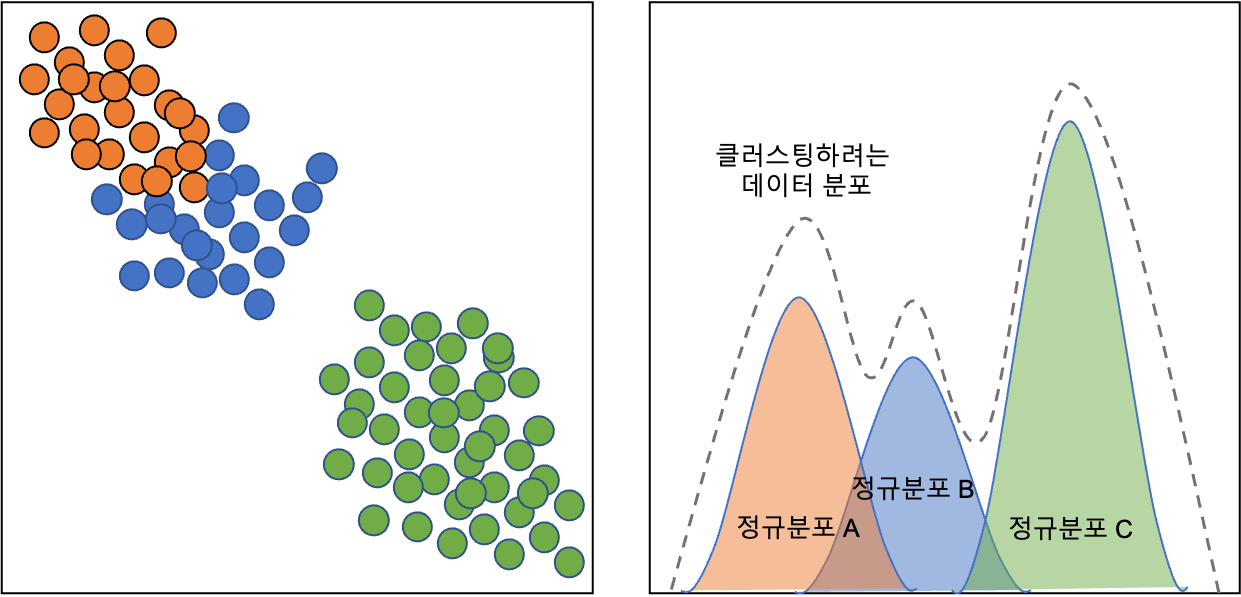

In [1]:
from IPython.display import Image

Image('gmm.png', width = 600)

In [2]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

irisDF = pd.DataFrame(data = iris.data, columns = feature_names)
irisDF['target'] = iris.target

#### GaussianMixture를 이용하여 붓꽃 데이터 군집화

In [4]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = 3, random_state = 0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

irisDF['gmm_cluster'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: gmm_cluster, dtype: int64


#### iris data K-Means 군집화 결과

In [5]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [7]:
kmeans = KMeans(n_clusters = 3, init='k-means++', max_iter = 300, random_state = 0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: kmeans_cluster, dtype: int64


#### 클러스터링 결과를 시각화하는 함수 생성

In [17]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter = True):
    # iscenter : 군집별 중심 위치
    if iscenter : 
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers = ['o', 's', '^', 'x', '*']
    
    # cluster 범위 값을 넘어가는 경우 noise로 처리
    isNoise = False
    
    for label in unique_labels :
        label_cluster = dataframe[dataframe[label_name]==label]
        
        if label == -1:
            cluster_legend = 'Noise'
            isNosie = True
        else:
            cluster_legend = 'Cluster '+str(label)
            
        plt.scatter(x = label_cluster['ftr1'], y = label_cluster['ftr2'], s = 70,
                    edgecolor = 'k', marker = markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x = center_x_y[0], y = center_x_y[1], s = 250, color = 'white',
                        alpha = 0.9, edgecolor = 'k', marker = markers[label])
            plt.scatter(x = center_x_y[0], y = center_x_y[1], s = 70, color = 'k',
                        edgecolor = 'k', marker = '$%d$' % label)
            
    if isNoise:
        legend_loc = 'upper center'
    else:
        legend_loc = 'upper right'

    plt.legend(loc=legend_loc)
    plt.show()

#### GMM 군집화와 K-Means 군집화를 비교하기 위해 타원형으로 늘어선 임의의 데이터 세트를 생성

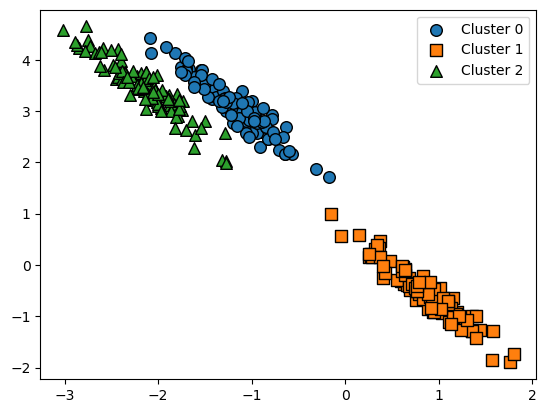

In [12]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 셋, 3개의 cluster 셋, cluster_std = 0.5로 생성
X, y = make_blobs(n_samples = 300, n_features =2, centers = 3, cluster_std = 0.5, random_state = 0)

# 길게 늘어난 타원형의 데이터 셋을 생성하기 위해 변환함
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

# feature 데이터 셋과 make_blobs()의 y 결과값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data = X_aniso, columns = ['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter = False)

#### K-Means 군집화 수행

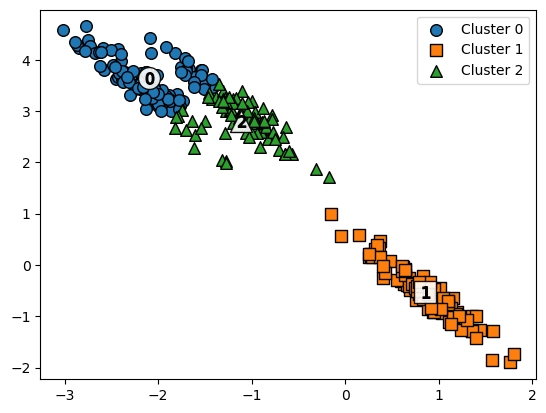

In [13]:
kmeans = KMeans(3, random_state = 0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmenas_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmenas_label', iscenter=True)

#### GMM 군집화 수행

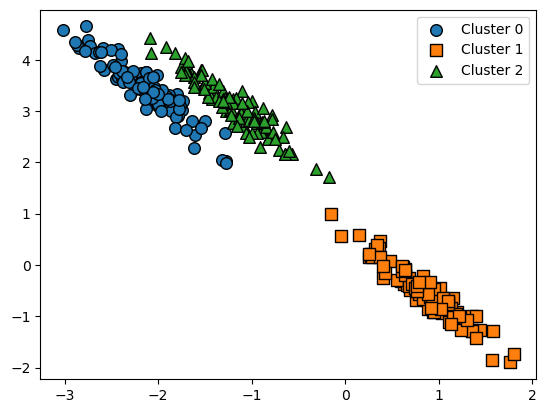

In [15]:
gmm = GaussianMixture(n_components = 3, random_state = 0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter = False)

#### GMM과 K_Means 군집화 결과 비교

In [16]:
print('### KMenas Clustering ###')
print(clusterDF.groupby('target')['kmenas_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMenas Clustering ###
target  kmenas_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmenas_label, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64
